In a new python environment with python>=3.10

In [ ]:
!pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev"

  Cloning https://github.com/ENSTA-U2IS-AI/torch-uncertainty (to revision dev) to /tmp/pip-install-1xk1ktfx/torch-uncertainty_0d75c9efb4904da69989ffb6af200437
  Running command git clone --filter=blob:none --quiet https://github.com/ENSTA-U2IS-AI/torch-uncertainty /tmp/pip-install-1xk1ktfx/torch-uncertainty_0d75c9efb4904da69989ffb6af200437
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/ENSTA-U2IS-AI/torch-uncertainty to commit 87c10220a90a2377489631c99b218b6b000210bb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# here are the training parameters
batch_size = 10
learning_rate =1e-3
weight_decay=2e-4
lr_decay_epochs=20
lr_decay=0.1
nb_epochs=50

In [ ]:
import torch
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

from torch_uncertainty.datasets import MUAD

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(root="./data", target_type="semantic", version="small", split="train" , transforms=train_transform, download=True)
val_set = MUAD(root="./data", target_type="semantic", version="small", split="val" , transforms=val_transform, download=True)
test_set = MUAD(root="./data", target_type="semantic", version="small", split="test" , transforms=val_transform, download=True)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [ ]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

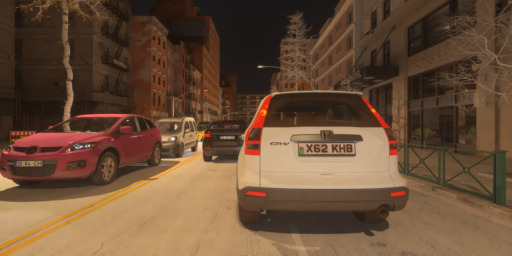

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

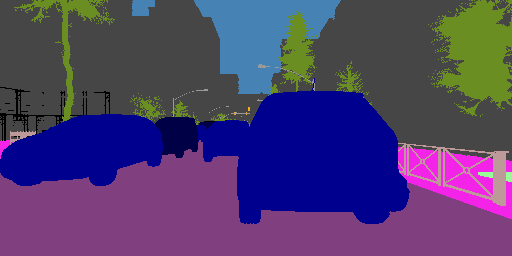

In [ ]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [ ]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

In [ ]:
tgt[0]

tensor([[2, 2, 2,  ..., 8, 8, 8],
        [2, 2, 2,  ..., 8, 8, 8],
        [2, 2, 2,  ..., 8, 8, 8],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

**Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**

I  think we can infer the reason directly from the array of values from <em> tgt </em> and the ids showed above: The white part corresponds to a object it must avoid and the image is black because each pixel carries the if of the expected class after segmentation.

**Q3/ please study the dataset a bit. What it is about?**



Synthetic dataset for autonomous driving, made with calculating uncertainty in mind, that is, the test set contains a variety of cases where like mistakes in the camera(lack of light for example), and  situations/objects that were not introduced in the training data appear(like a climatic event or a new vehicle/type of building).

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


I will adapt some of the code to run o CPU when correcting stuff and don't waste the Colab Credits.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
      label = label.cpu().numpy()
      # Flatten label
      flat_label = label.flatten()
      flat_label = flat_label[flat_label != 255]

      # Sum up the number of pixels of each class and the total pixel
      # counts for each label
      class_count += np.bincount(flat_label, minlength=num_classes)
      total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [ ]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().to(device)
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444, 50.4983,  5.2256, 21.1894, 50.4983,
        50.4983, 50.4983, 50.4983])


**Q4/ why do we need to evaluate the class_weights?**

Some of the classes won't be as frequent as others. Using weights provides a way of not letting the model use this lower frequence as a criteria to discredit such label and using a more frequent one to wrongly label an object.

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**

I put some comments in the part that seems to be the different one. This UNet is doing a bilinear interpolation for the upscaling part of the network.

The main difference between this and the ConvTranspose seems to be the fact that the Bilinear Interpolation will always consider that closest pixels(related to the pixel we want to calculate the new value) as the most important, so they receive big weights in the interpolation. The Convolution of course uses learnable weights, and so the assumption 'the closest pixels are more important' is not always true.

The original paper also doesn't metion any dropout layers, so that also one of the differences, although I think it's a minor one. And last, but not least,  our channels also don't get so big. In the original paper, right before the upscaling, the channel amount gets up to 1024, but ours is limited to 512.

**Q6/Do we need a backbone with Unet?**

I think that a path of contracting and then upsampling can only achieve so much in feature extraction. I imagine that if the features have a very big spatial dependence(bigger than the receptive field in the CNNs) or even a temporal one, UNet would be too weak to extract it with its parameters and strategies.




In [ ]:
from torch import nn


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),#image keeps size with padding
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear#the keyword that sets the difference

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:#this is the different part
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)#it does a linearinterpolation of the values in x1
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

#please note that we have added dropout layer to be abble to use MC dropout

class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [ ]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?**


It is the Jaccard Index between two sets of pixels, the one resulting from the predicted bounding box of an object, and the ground truth. If $\mathcal{A}$ is our predicted bounding box and $\mathcal{B}$ is the ground truth, the Jaccard Index $\mathcal{J}$ is:

$$
\mathcal{J}(\mathcal{A},\mathcal{B}) = \frac{|\mathcal{A}⋂\mathcal{B}|}{|\mathcal{A}\bigcup\mathcal{B}|}
$$

It can be used to measure how accurate a predicted class's cell is compared to the ground truth.

### Training function

**Q8/Please complete the training and the test function**

I'll leave the comments in the code

In [ ]:
from torchmetrics.utilities.compute import _safe_divide
from tqdm import tqdm

def train( model, data_loader, optim, criterion, device,metric,iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(tqdm(data_loader)):
        optim.zero_grad()
        # Get the inputs and labels
        img = batch_data[0].to(device)
        labels = batch_data[1].to(device)
        labels=labels.squeeze(1)
        # Forward propagation
        outputs = model(img)
        flatten_logits = outputs.argmax(dim=1,keepdim=True).view(-1)
        flatten_labels = labels.view(-1)
        # Loss computation
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        optim.step()
        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        valid_mask = flatten_labels != 255
        #we detach to dont put 'metrics' in the computational graph
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

### Validation function

In [ ]:
def test(model, data_loader, criterion, metric, device,iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(tqdm(data_loader)):
        # Get the inputs and labels
        img = batch_data[0].to(device)
        labels = batch_data[1].to(device)
        labels=labels.squeeze(1)
        with torch.no_grad():

            # Forward propagation
            outputs = model(img)
            flatten_logits = outputs.argmax(dim=1,keepdim=True).view(-1)
            flatten_labels = labels.view(-1)
            # Loss computation
            loss = criterion(outputs, labels)
            # Keep track of loss for current epoch
            epoch_loss += loss.item()

            # Keep track of the evaluation metric

            valid_mask = flatten_labels != 255
            metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])


        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

## E. Training Process

**Q9/ please train your DNN and comment?**



In [ ]:
from torch import optim
from torch.optim import lr_scheduler

from torch.nn import CrossEntropyLoss

from torch_uncertainty.metrics.classification import MeanIntersectionOverUnion


In [ ]:
print("\nTraining...\n")
num_classes = 19
# Intialize UNet
model = UNet(classes=num_classes)
model.to(device)
# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion  combines LogSoftMax and NLLLoss.
criterion = CrossEntropyLoss(weight=class_weights,ignore_index=255)
criterion.to(device)
metric = MeanIntersectionOverUnion(num_classes=num_classes)
metric.to(device)
optimizer = optim.Adam(model.parameters(),lr = learning_rate,weight_decay=weight_decay)
#lrate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Training...



In [ ]:
from numpy import inf

# Start Training

n_epochs = 50
train_loss_history = []
val_loss_history = []
train_miou_history = []
val_miou_history = []
best_vall_loss = inf#so we can save or not the model

for epoch in range(n_epochs):

    train_epoch_loss, train_epoch_iou, train_epoch_miou = train(model, train_loader, optimizer, criterion, device,metric)
    test_epoch_loss, test_epoch_iou, test_epoch_miou = test(model, val_loader, criterion, metric, device)
    print("[Epoch: {}] Training".format(epoch))
    print("[Epoch: {}] Avg. loss: {} | Mean IoU: {}".format(epoch,train_epoch_loss,  train_epoch_miou))
    if epoch%5 == 0:
        print("[Epoch: {}] Validation".format(epoch))
        print("[Epoch: {}] Avg. loss: {} | Mean IoU: {}".format(epoch,test_epoch_loss,  test_epoch_miou))

    if test_epoch_loss < best_vall_loss:#we save only if val_loss decreases
        best_vall_loss = test_epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bestloss': best_vall_loss
            }, "model.pth.tar")
        print("Model saved")
    train_loss_history.append(train_epoch_loss)
    val_loss_history.append(test_epoch_loss)
    train_miou_history.append(train_epoch_miou)
    val_miou_history.append(test_epoch_miou)



  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


[Epoch: 0] Training
[Epoch: 0] Avg. loss: 2.107762596011162 | Mean IoU: 0.06751621514558792
[Epoch: 0] Validation
[Epoch: 0] Avg. loss: 2.695261240005493 | Mean IoU: 0.08146090060472488
Model saved


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


[Epoch: 1] Training
[Epoch: 1] Avg. loss: 1.8207906007766723 | Mean IoU: 0.1338425576686859
Model saved


100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


[Epoch: 2] Training
[Epoch: 2] Avg. loss: 1.6331902205944062 | Mean IoU: 0.1657940298318863
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 3] Training
[Epoch: 3] Avg. loss: 1.468316063284874 | Mean IoU: 0.19417878985404968
Model saved


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


[Epoch: 4] Training
[Epoch: 4] Avg. loss: 1.350408685207367 | Mean IoU: 0.21666792035102844


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


[Epoch: 5] Training
[Epoch: 5] Avg. loss: 1.3230074048042297 | Mean IoU: 0.22751641273498535
[Epoch: 5] Validation
[Epoch: 5] Avg. loss: 1.532332460085551 | Mean IoU: 0.18017953634262085


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


[Epoch: 6] Training
[Epoch: 6] Avg. loss: 1.276651468873024 | Mean IoU: 0.22870232164859772


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


[Epoch: 7] Training
[Epoch: 7] Avg. loss: 1.2388411968946458 | Mean IoU: 0.2418675422668457
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


[Epoch: 8] Training
[Epoch: 8] Avg. loss: 1.202188217639923 | Mean IoU: 0.2529548108577728


100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


[Epoch: 9] Training
[Epoch: 9] Avg. loss: 1.1443791151046754 | Mean IoU: 0.26165375113487244


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 10] Training
[Epoch: 10] Avg. loss: 1.1241121008992194 | Mean IoU: 0.2663780152797699
[Epoch: 10] Validation
[Epoch: 10] Avg. loss: 1.086698293685913 | Mean IoU: 0.26230132579803467
Model saved


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


[Epoch: 11] Training
[Epoch: 11] Avg. loss: 1.078240029513836 | Mean IoU: 0.27519410848617554


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 12] Training
[Epoch: 12] Avg. loss: 1.0459579095244407 | Mean IoU: 0.2809916138648987


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


[Epoch: 13] Training
[Epoch: 13] Avg. loss: 1.0576916322112084 | Mean IoU: 0.27861112356185913


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 14] Training
[Epoch: 14] Avg. loss: 1.0157962903380393 | Mean IoU: 0.28667667508125305


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


[Epoch: 15] Training
[Epoch: 15] Avg. loss: 0.968824391067028 | Mean IoU: 0.29168227314949036
[Epoch: 15] Validation
[Epoch: 15] Avg. loss: 1.1017738282680511 | Mean IoU: 0.2453903704881668


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


[Epoch: 16] Training
[Epoch: 16] Avg. loss: 0.9320408046245575 | Mean IoU: 0.30606263875961304


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


[Epoch: 17] Training
[Epoch: 17] Avg. loss: 0.9441155076026917 | Mean IoU: 0.30149486660957336
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 18] Training
[Epoch: 18] Avg. loss: 0.9092315390706063 | Mean IoU: 0.3142600655555725
Model saved


100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


[Epoch: 19] Training
[Epoch: 19] Avg. loss: 0.8847202241420746 | Mean IoU: 0.31980863213539124
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


[Epoch: 20] Training
[Epoch: 20] Avg. loss: 0.8854473635554314 | Mean IoU: 0.3214530050754547
[Epoch: 20] Validation
[Epoch: 20] Avg. loss: 0.9609283705552419 | Mean IoU: 0.27125415205955505


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


[Epoch: 21] Training
[Epoch: 21] Avg. loss: 0.8620214000344276 | Mean IoU: 0.3288591802120209


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 22] Training
[Epoch: 22] Avg. loss: 0.8862862899899483 | Mean IoU: 0.3235960900783539


100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


[Epoch: 23] Training
[Epoch: 23] Avg. loss: 0.8370120123028755 | Mean IoU: 0.3374854624271393
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 24] Training
[Epoch: 24] Avg. loss: 0.8273244693875312 | Mean IoU: 0.34581926465034485


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


[Epoch: 25] Training
[Epoch: 25] Avg. loss: 0.8054693371057511 | Mean IoU: 0.3417937457561493
[Epoch: 25] Validation
[Epoch: 25] Avg. loss: 1.0517517228921254 | Mean IoU: 0.30571696162223816


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


[Epoch: 26] Training
[Epoch: 26] Avg. loss: 0.7986250177025795 | Mean IoU: 0.35137656331062317


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


[Epoch: 27] Training
[Epoch: 27] Avg. loss: 0.7834089919924736 | Mean IoU: 0.3571172058582306
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


[Epoch: 28] Training
[Epoch: 28] Avg. loss: 0.7342240214347839 | Mean IoU: 0.3752100169658661


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


[Epoch: 29] Training
[Epoch: 29] Avg. loss: 0.7464161157608032 | Mean IoU: 0.36952468752861023
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


[Epoch: 30] Training
[Epoch: 30] Avg. loss: 0.7686248496174812 | Mean IoU: 0.36963993310928345
[Epoch: 30] Validation
[Epoch: 30] Avg. loss: 0.8734537065029144 | Mean IoU: 0.3413415849208832


100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


[Epoch: 31] Training
[Epoch: 31] Avg. loss: 0.7137770861387253 | Mean IoU: 0.3795909285545349
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 32] Training
[Epoch: 32] Avg. loss: 0.7143958404660224 | Mean IoU: 0.38445523381233215


100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


[Epoch: 33] Training
[Epoch: 33] Avg. loss: 0.6996393412351608 | Mean IoU: 0.3883143961429596


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


[Epoch: 34] Training
[Epoch: 34] Avg. loss: 0.6947401121258736 | Mean IoU: 0.39453431963920593


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


[Epoch: 35] Training
[Epoch: 35] Avg. loss: 0.686997888982296 | Mean IoU: 0.4004071056842804
[Epoch: 35] Validation
[Epoch: 35] Avg. loss: 0.7719934582710266 | Mean IoU: 0.32758453488349915
Model saved


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 36] Training
[Epoch: 36] Avg. loss: 0.6404608771204948 | Mean IoU: 0.41378054022789
Model saved


100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


[Epoch: 37] Training
[Epoch: 37] Avg. loss: 0.6245384097099305 | Mean IoU: 0.41531902551651


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


[Epoch: 38] Training
[Epoch: 38] Avg. loss: 0.6389850497245788 | Mean IoU: 0.4154667854309082


100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


[Epoch: 39] Training
[Epoch: 39] Avg. loss: 0.6038822136819363 | Mean IoU: 0.42477110028266907


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


[Epoch: 40] Training
[Epoch: 40] Avg. loss: 0.5837878428399563 | Mean IoU: 0.4419826865196228
[Epoch: 40] Validation
[Epoch: 40] Avg. loss: 0.7246245642503103 | Mean IoU: 0.3705771565437317


100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


[Epoch: 41] Training
[Epoch: 41] Avg. loss: 0.5714569218456745 | Mean IoU: 0.4493110775947571


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[Epoch: 42] Training
[Epoch: 42] Avg. loss: 0.5836732849478722 | Mean IoU: 0.4380051791667938
Model saved


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


[Epoch: 43] Training
[Epoch: 43] Avg. loss: 0.5836913004517555 | Mean IoU: 0.43386465311050415


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


[Epoch: 44] Training
[Epoch: 44] Avg. loss: 0.546323861926794 | Mean IoU: 0.4578341841697693
Model saved


100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


[Epoch: 45] Training
[Epoch: 45] Avg. loss: 0.5367383003234864 | Mean IoU: 0.46362802386283875
[Epoch: 45] Validation
[Epoch: 45] Avg. loss: 0.7804139057795206 | Mean IoU: 0.37237921357154846


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


[Epoch: 46] Training
[Epoch: 46] Avg. loss: 0.513808723539114 | Mean IoU: 0.4707995057106018


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


[Epoch: 47] Training
[Epoch: 47] Avg. loss: 0.5435251586139203 | Mean IoU: 0.4522381126880646


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


[Epoch: 48] Training
[Epoch: 48] Avg. loss: 0.5368959732353688 | Mean IoU: 0.4545447528362274


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]

[Epoch: 49] Training
[Epoch: 49] Avg. loss: 0.5105886481702328 | Mean IoU: 0.47224897146224976
Model saved


Load a model so we don't train from scratch(I'll be appending it with the notebook).

This is the model defined above, using 50 epochs for training, an Adam optimizer with learning rate of $3.10^{-2}$.

I'm loading the model afterwards since the Temperature Scaling part can be done in CPU and save the credits for later. I didn't save the training and validation metrics throughout iterations but the plots can still be seen in their proper section.

In [ ]:
#Loading a model
model = UNet(19)
checkpoint_save = torch.load("model.pth.tar",weights_only=True,map_location=device)
model.load_state_dict(checkpoint_save['model_state_dict'])
model = model.to(device)

best_val_loss = checkpoint_save['bestloss']

epoch = checkpoint_save['epoch']

optimizer = optim.Adam(model.parameters(),lr = learning_rate,weight_decay=weight_decay)
optimizer.load_state_dict(checkpoint_save['optimizer_state_dict'])


# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**


We can observe the model overfits after a certain time-step.

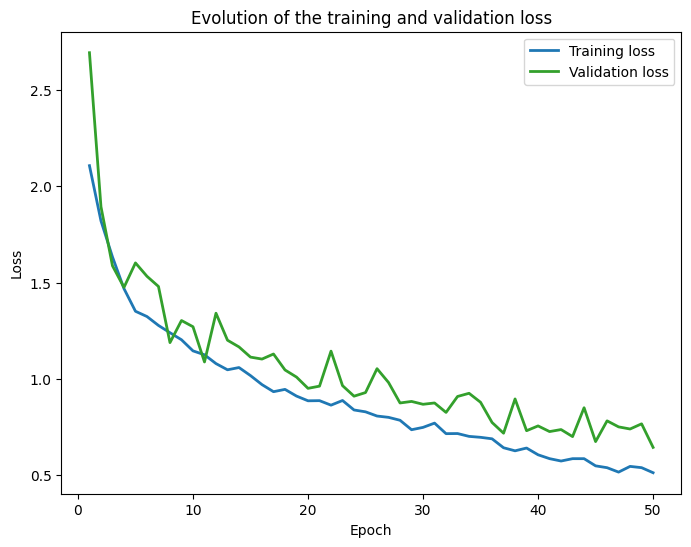

In [ ]:
plot_losses(train_loss_history, val_loss_history)

In [ ]:
val_miou_history = [tensor.to('cpu').detach().numpy() for tensor in val_miou_history]
train_miou_history = [tensor.to('cpu').detach().numpy() for tensor in train_miou_history]

AttributeError: 'numpy.ndarray' object has no attribute 'to'

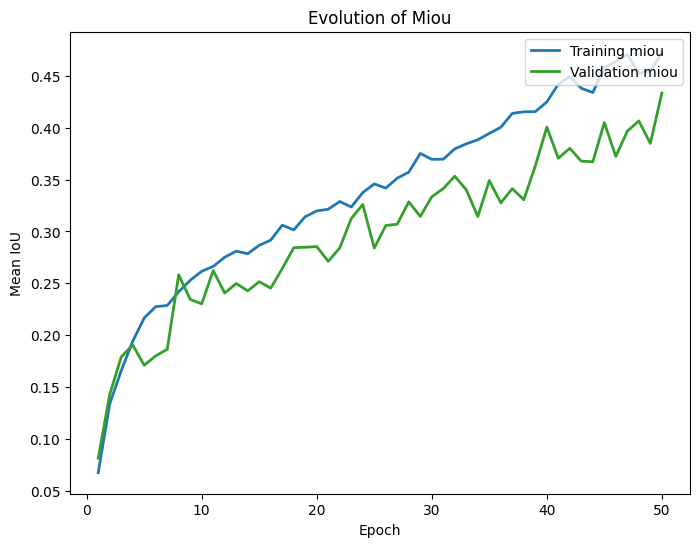

In [ ]:
plot_accu(train_miou_history, val_miou_history)

**Q11/ what should we have done to avoid overfitting?**


After reading the original UNet paper, there are 2 main differences to the treatment we did here:

1. Weight initialization, the paper mentions using a Gaussian distribution to get the initial weights and avoid over-activation of some of the layers;

2. The balancing between each class is not made only by <em> frequence </em>, but also by taking into account the separation borders between the segmentation of the ground truth.

Although both could explain the disproportion between the classes, the 2nd point, to me, appears to be the main reason for the misrepresentation for them.



I changed the loop we made here, but I think the idea stays the same, we just show the IoU for the classes after training and see which ones were better classified.

In [ ]:
loss, iou, miou = test(model, test_loader, criterion, metric,device)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss ," | Mean IoU: ", miou)

for id,muad_class in enumerate(train_set.classes[:len(iou)]):
    class_name = muad_class.name
    print(f"Class: {class_name}: {iou[id]:.4f}")

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [00:20<00:00,  1.67s/it]

>>>> [FINAL TEST on the test set: ] Avg. loss:  2.9953016440073648  | Mean IoU:  tensor(0.0025, device='cuda:0')
Class: road: 0.0000
Class: sidewalk: 0.0000
Class: building: 0.0000
Class: wall: 0.0000
Class: fence: 0.0000
Class: pole: 0.0001
Class: traffic_light: 0.0000
Class: traffic_sign: 0.0000
Class: vegetation: 0.0000
Class: terrain: 0.0008
Class: sky: 0.0334
Class: person: 0.0000
Class: rider: nan
Class: car: 0.0000
Class: truck: 0.0000
Class: bus: nan
Class: train: nan
Class: motorcycle: nan
Class: bicycle: nan


So we can see the most frequent categories are still better classified(cars, sky and the road).

## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [54]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	print(outputs.shape)
	print(outputs_proba.shape)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)
	print(pred.shape)

torch.Size([1, 19, 256, 512])
torch.Size([1, 19, 256, 512])
torch.Size([256, 512])


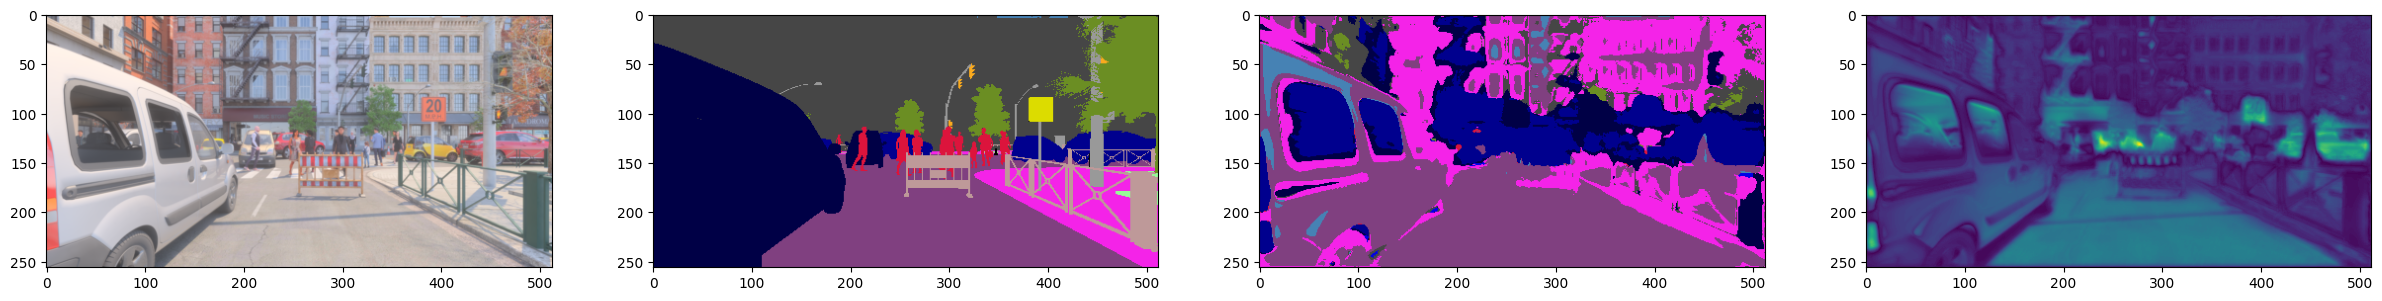

In [44]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**

As we see in the code above, confidence collects the maximum probabilites the model predicts for the classes in each one of the image's pixels, that means, that for each pixel, we got the highest value between the probabilities between the classes.

So, the bright areas represent results the model is pretty confident on, brighter as this probability reaches 1. The darker parts of this 'heat image' tell us that the probability given by the model to the class of this part is very low, meaning that the model cannot differentiate it significantly from the others.


### Now let's load the OOD test set

In [ ]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [41]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

NameError: name 'test_ood_set' is not defined

In [42]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

RuntimeError: The size of tensor a (19) must match the size of tensor b (22) at non-singleton dimension 0

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**

Not at all, since we didn't have neither the bear or the goat as categories during the classification(we only used the first 19 ones and they're at the end). It also seems the model mixes them with the background, the road, or other objects in the picture. We can see this by the lack of borders/frontiers.


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**

Answered in the first Question 12


## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

I'll be basically doing the documentation's guide in the Calibration part, so I'll keep things brief.

In [ ]:
num_classes=19

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


  8%|▊         | 1/12 [00:42<07:48, 42.59s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 17%|█▋        | 2/12 [01:01<04:46, 28.65s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 25%|██▌       | 3/12 [01:18<03:31, 23.48s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 33%|███▎      | 4/12 [01:33<02:41, 20.17s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 42%|████▏     | 5/12 [01:46<02:03, 17.57s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 50%|█████     | 6/12 [02:02<01:40, 16.75s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 58%|█████▊    | 7/12 [02:17<01:21, 16.34s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 67%|██████▋   | 8/12 [02:30<01:01, 15.31s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 75%|███████▌  | 9/12 [02:44<00:44, 14.86s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 83%|████████▎ | 10/12 [02:59<00:29, 14.98s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


100%|██████████| 12/12 [03:16<00:00, 11.11s/it]

torch.Size([2, 19, 256, 512])
torch.Size([2, 256, 512])


100%|██████████| 12/12 [03:16<00:00, 16.42s/it]


ECE before scaling - 3.518%.


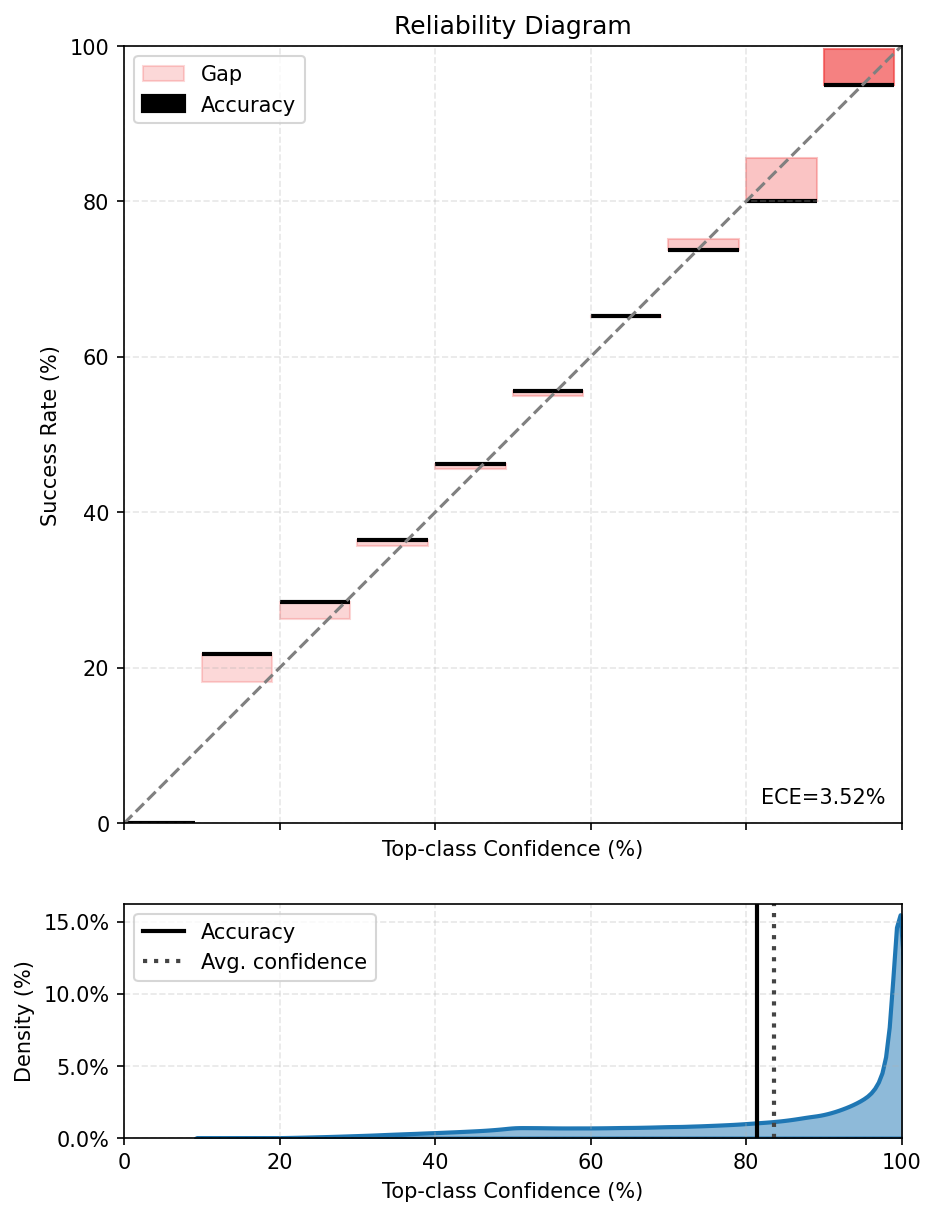

In [ ]:
from torch_uncertainty.metrics import CalibrationError

model.to(device)
ece = CalibrationError(task="multiclass", num_classes=num_classes)

ece.to(device) #I imagine it has to be in the same device as the model



for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    #outputs,_ = torch.max(outputs,dim=1)
    targets=targets.squeeze(1)
    print(outputs.shape)
    print(targets.shape)
    ece.update(outputs, targets)


print(f"ECE before scaling - {ece.compute():.3%}.")

fig, ax = ece.plot()
fig.show()

**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

Overconfidence. We see and the first and second graphs that the model overestimates alot in the most frequent classes(top right).

After temperature scaling

In [ ]:
from torch_uncertainty.post_processing import TemperatureScaler

#it's a pretty stupid way of doing things, but I needed to squeeze the target's
#dimension to use it in the Loss. I also didn't wanna to download more data, so
#I just used a dataloader to split the test dataset
cal_loader = DataLoader(test_set,batch_size=len(test_set),shuffle=False)
inputs,targets = next(iter(cal_loader))
merged_dataset = torch.utils.data.TensorDataset(inputs, (targets.masked_fill_(targets == 255,18)).squeeze(1))
#since anoter CrossEntropy was created by TemperatureScaler, I just mapped all
#white pixels of the target to one of the subutilised classes of the dataset.
cal_len = len(merged_dataset)//2

cal_set,new_test_set = torch.utils.data.random_split(merged_dataset,[cal_len,len(merged_dataset) - cal_len])


test_loader = DataLoader(new_test_set,batch_size=batch_size,shuffle=False,num_workers=4)


model.to(device)#iteration is takng 30s each, so its fine

scaled_model = TemperatureScaler(model=model)
#Here I would like to mention two things:

#1. It seems that after caling scaled_model.fit() with the calibration set, torch_uncertainty
#creates a new dataloader with a fixed batch_size of 32. That seems weird if we'rex'
#using heavy data(for which we need low batch_sizes).

#2. The Temperature Scaler inherits from the Scaler class, that automatically uses
#CrossEntropyLoss. But, in this problem, we should ignore the '255'(white) values in the
#target. It could simply be resolved by passing the ignore_index parameter while declaring
#the loss, but since it's automatically created by torch_uncertainty, we can't do that.

scaled_model.fit(calibration_set=cal_set)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 2/2 [01:02<00:00, 31.02s/it]


In [ ]:
del cal_set #freeing up some space since we're on a 12gb CPU

In [ ]:
ece.reset()

# Iterate on the test dataloader
for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = scaled_model(inputs)
    #outputs,_ = torch.max(outputs,dim=1)
    #targets=targets.squeeze(1)
    print(outputs.shape)
    print(targets.shape)
    ece.update(outputs, targets)

print(f"ECE after scaling - {ece.compute():.3%}.")

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 17%|█▋        | 1/6 [00:12<01:00, 12.12s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 33%|███▎      | 2/6 [00:23<00:46, 11.58s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 50%|█████     | 3/6 [00:31<00:30, 10.10s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 67%|██████▋   | 4/6 [00:42<00:21, 10.57s/it]

torch.Size([10, 19, 256, 512])
torch.Size([10, 256, 512])


 83%|████████▎ | 5/6 [00:51<00:09,  9.75s/it]

torch.Size([6, 19, 256, 512])
torch.Size([6, 256, 512])


100%|██████████| 6/6 [00:59<00:00,  9.87s/it]


ECE after scaling - 3.595%.


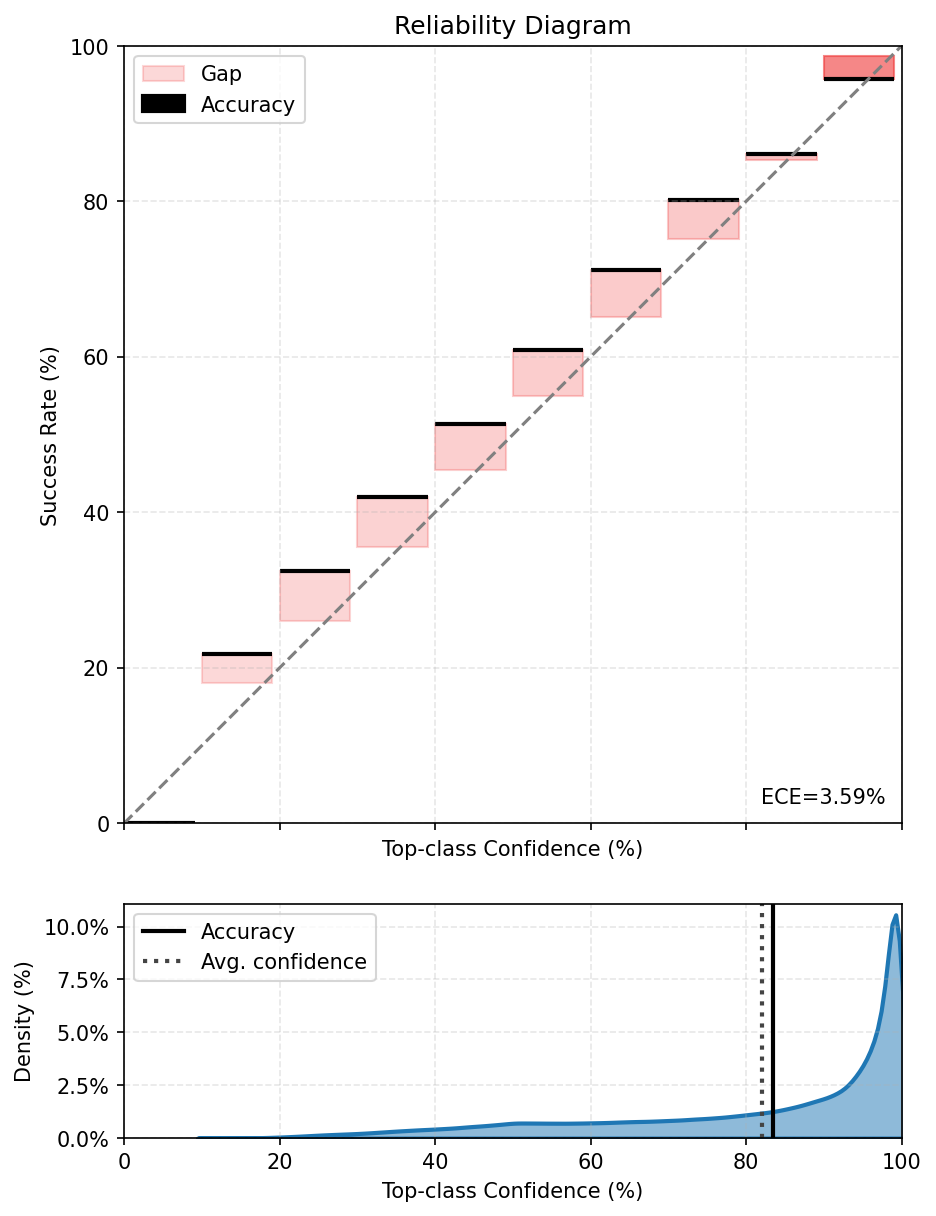

In [ ]:
fig, ax = ece.plot()
fig.show()

In my tests, we got a $\approx$ 0.4% improvement in the ECE and a 10% decrease in the density of the top-classes. The gap that was concentrated at the top right seems to be weaker, and the gaps between the other classes got a bit bigger. Although it may seem the prediction got worse, taking some of the gap out of the top right of the plot means a smaller error in the most frequent classes, which is better overall.

---



Now let's see the new confidence score image after scaling

In [52]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
scaled_model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = scaled_model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

NameError: name 'scaled_model' is not defined

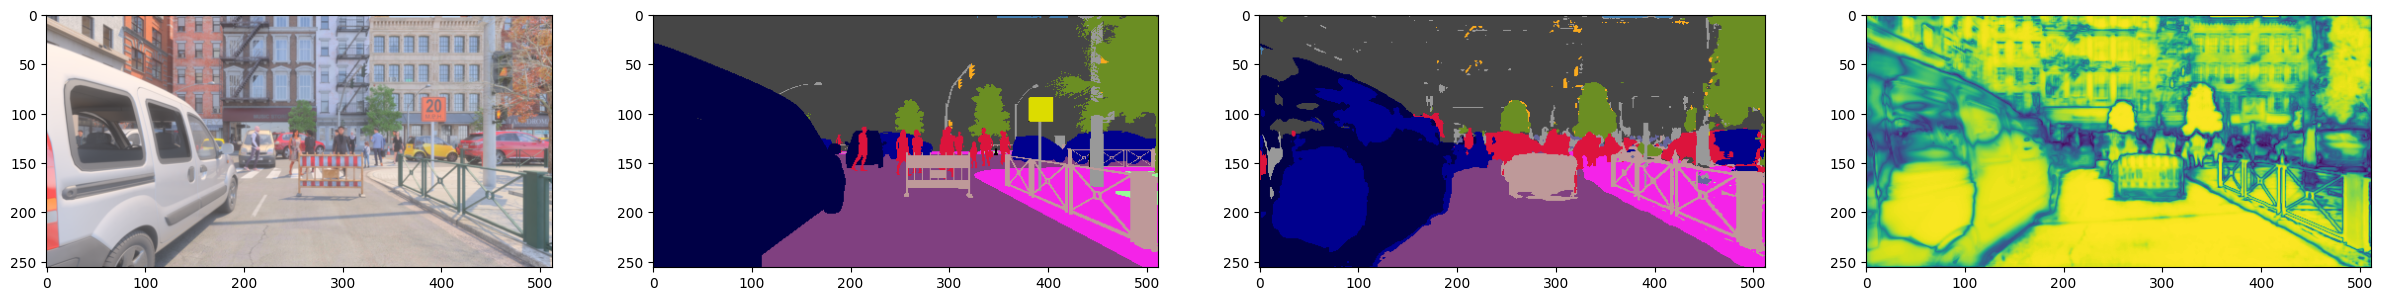

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**

I would say it's better calibrated, meaning that the confidence heat map didn't get any brighter, only that the model became better in differentiating alot of the objects, the border between some of them is now easily seen.

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

Again, most of the things are used directly from the <em> Quick Start </em> guide in the documentation, so I'll only leave some comments in the code.

Since the training will be done directly through the library(since the dataloading will be all different due to the estimators and such), we'll also be importing more things, like the Trainer and the DataModule for the dataset.

In [ ]:
if 'model' in globals():
  del model
if 'optimizer' in globals():
  del optimizer
if 'criterion' in globals():
  del criterion

Now, the current DataModule for MUAD in the library will try to download all the dataset, and since we have no space in Colab for such thing I'll just define a new Class for the data we have here.

In [ ]:
from torch_uncertainty.datamodules.abstract import TUDataModule
from numpy.typing import ArrayLike

class MyDataModule(TUDataModule):
    training_task = "segmentation"
    def __init__(self, root,train_set,val_set,test_set, batch_size, num_workers)-> None:
      super().__init__(root,
                         batch_size,
                         num_workers=1,
                         val_split = None,
                         pin_memory=True,
                         persistent_workers=True)
      self.train = train_set
      self.val = val_set
      self.test = test_set

    def setup(self, stage: str | None = None) -> None:
      #now this, to me, seems a bit unecessary, but I was afraid about not
      #doing a proper setup method and messing up all the training module
      #since all data was already partitioned at the beggining of the colab and
      #I def. didn´t want to download everything again, I'll let it like this
      if stage == "fit" or stage is None:
        self.train = self.train
        self.val = self.val
      elif stage == 'test':
        self.test = self.test
      else:
        raise ValueError(f"Stage {stage} not supported.")

    def _get_train_data(self) -> ArrayLike:
        return self.train.samples

    def _get_train_targets(self) -> ArrayLike:
        return self.train.targets

In [45]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout

#library does not import MUADDataModule at __init__.py
from torch_uncertainty.datamodules.segmentation import MUADDataModule
from torch_uncertainty import TUTrainer
from torch_uncertainty.routines import SegmentationRoutine
dm = MyDataModule(root="./data", batch_size=batch_size, num_workers=4,
                  train_set=train_set,
                  val_set=val_set,
                  test_set=test_set)
#dm.setup()
#dm.setup()

trainer = TUTrainer(accelerator="cpu", max_epochs=2,
                    enable_progress_bar=False,
                    log_every_n_steps=10)
model = UNet(num_classes)
model.to(device)

model_mc3t = mc_dropout(model, num_estimators = 3, last_layer = False)
model_mc3t.to(device)

def optim_recipe(model, lr_mult: float = 1.0):#to pass the recipe
    optimizer = optim.Adam(model.parameters(), lr=learning_rate * lr_mult,weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    return {"optimizer": optimizer, "scheduler": scheduler}


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [46]:
routine3t = SegmentationRoutine(
    num_classes=num_classes,
    model=model_mc3t,
    loss=nn.CrossEntropyLoss(weight=class_weights,ignore_index=255),
    optim_recipe=optim_recipe(model_mc3t)
)

In [36]:
trainer.fit(model=routine3t, datamodule=dm)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'scheduler'}
INFO: 
  | Name                    | Type             | Params | Mode 
---------------------------------------------------------------------
0 | model                   | MCDropout        | 3.7 M  | train
1 | loss                    | CrossEntropyLoss | 0      | train
2 | format_batch_fn         | Identity         | 0      | train
3 | val_seg_metrics         | MetricCollection | 0      | train
4 | val_sbsmpl_seg_metrics  | MetricCollection | 0      | train
5 | test_seg_metrics        | MetricCollection | 0      | train
6 | test_sbsmpl_seg_metrics | MetricCollection | 0      | train
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.806    Total estimated model params size (MB)
122       Modules in train mode
0         Modules in eval mod

NameError: name 'exit' is not defined

In [61]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
routine3t.eval()
with torch.no_grad():
	# Forward propagation
	outputs = routine3t(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	outputs_proba,_ = outputs_proba.max(1)
	print(outputs.shape)
	print(outputs_proba.shape)
	confidence, pred = outputs_proba.max(0)
	print(pred.shape)

torch.Size([3, 19, 256, 512])
torch.Size([3, 256, 512])
torch.Size([256, 512])


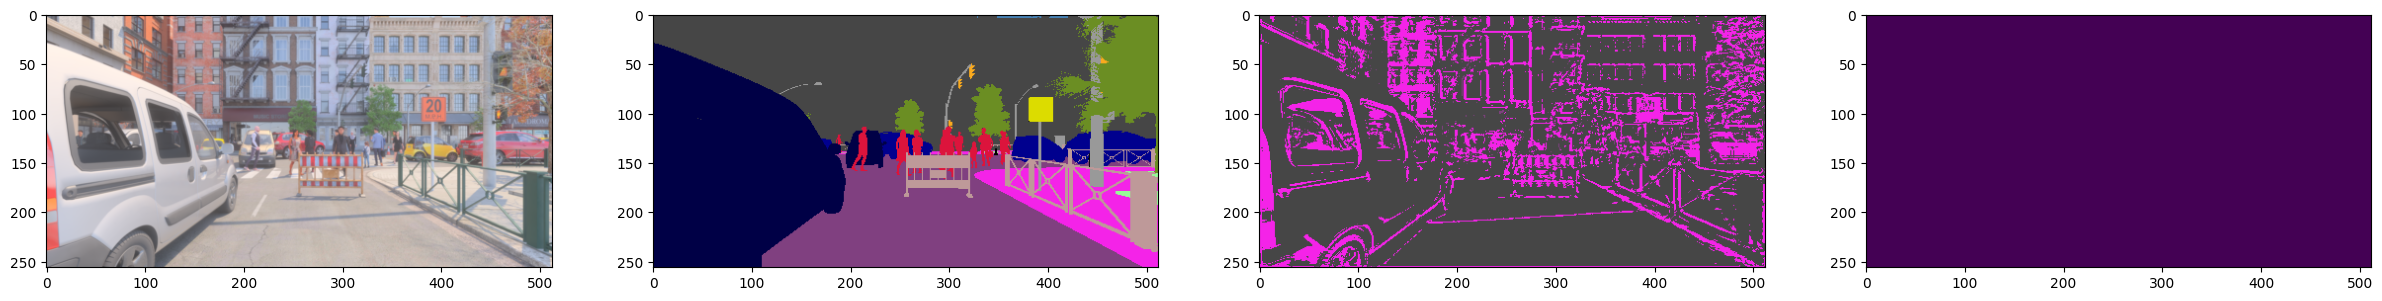

In [62]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

We now do it for the model with 16 estimators.

In [ ]:
if 'model' in globals():
  del model
  del routine3t
if 'optimizer' in globals():
  del optimizer
if 'criterion' in globals():
  del criterion

In [ ]:
model = UNet(num_classes)
model.to(device)

model_mc16t = mc_dropout(model, num_estimators = 16, last_layer = False)
model_mc16t.to(device)


In [ ]:
routine16t = SegmentationRoutine(
    num_classes=num_classes,
    model=model_mc16t,
    loss=nn.CrossEntropyLoss(weight=class_weights,ignore_index=255),
    optim_recipe=optim_recipe(model_mc16t)

In [ ]:
trainer.fit(model=routine3t, datamodule=dm)

In [55]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
routine16t.eval()
with torch.no_grad():
	# Forward propagation
	outputs = routine16t(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	outputs_proba,_ = outputs_proba.max(1)
	print(outputs.shape)
	print(outputs_proba.shape)
	confidence, pred = outputs_proba.max(0)
	print(pred.shape)

NameError: name 'routine16t' is not defined

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

GPU Credits ran out before completing everything, the 50 epoch model took too long.

**Try the MC dropout code with a low number of estimators T like 3 and a high number 20, Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

Since I'm out of GPU credits, I'll just leave the code for making the routine and the train fit.

In [63]:
from torch_uncertainty.models import deep_ensembles

In [65]:
model = UNet(num_classes)
model.to(device)

ensemble = deep_ensembles(model,
                          num_estimators=3,
                          task = 'segmentation'
                          ,reset_model_parameters=True,
                          )
ensemble.to(device)

_DeepEnsembles(
  (core_models): ModuleList(
    (0-2): 3 x UNet(
      (inc): InConv(
        (conv): DoubleConv(
          (conv): Sequential(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU(inplace=True)
          )
        )
      )
      (down1): Down(
        (mpconv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (conv): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          

In [67]:
routine_ensemble = SegmentationRoutine(
    num_classes=num_classes,
    model=ensemble,
    loss=nn.CrossEntropyLoss(weight=class_weights,ignore_index=255),
    optim_recipe=optim_recipe(model)

)

In [68]:
trainer.fit(model=routine_ensemble,datamodule=dm)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'scheduler'}
INFO: 
  | Name                    | Type             | Params | Mode 
---------------------------------------------------------------------
0 | model                   | _DeepEnsembles   | 11.1 M | train
1 | loss                    | CrossEntropyLoss | 0      | train
2 | format_batch_fn         | Identity         | 0      | train
3 | val_seg_metrics         | MetricCollection | 0      | train
4 | val_sbsmpl_seg_metrics  | MetricCollection | 0      | train
5 | test_seg_metrics        | MetricCollection | 0      | train
6 | test_sbsmpl_seg_metrics | MetricCollection | 0      | train
---------------------------------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.418    Total estimated model params size (MB)
317       Modules in train mode
0         Modules in eval mod

NameError: name 'exit' is not defined

Test your ensemble obtained either using option 1 or 2.

In [ ]:
results = trainer.test(routine_ensemble, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃       Segmentation        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Brier     │          0.21573          │
│     NLL      │          0.42458          │
│     mAcc     │          64.12%           │
│     mIoU     │          49.53%           │
│    pixAcc    │          85.44%           │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.04905          │
│     aECE     │          0.04905          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │           2.92%           │
│     AURC     │           3.67%           │
└──────────────┴───────────────────────────┘

Save the ensemble model

In [ ]:
final_model_path = "ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to ensemble.pth


## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/alafage/miniconda3/envs/test_tp/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alafage/thesis/torch-uncertainty/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                    | Type             | Params | Mode 
---------------------------------------------------------------------
0 | model                   | PackedUNet       | 2.1 M  | train
1 | loss                    | CrossEntropyLoss | 0      | train
2 | format_batch_fn         | RepeatTarget     | 0      | train
3 | val_seg_metrics         | MetricCollection | 0      | train
4 | val_sbsmpl_seg_metrics  | MetricCollection | 0      | train
5 | test_seg_metrics        | MetricCollection | 0      | train
6 | test_sbsmpl_seg_metrics | MetricCollection | 0      | train
---------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total pa

Epoch 49: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃       Segmentation        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Brier     │          0.41144          │
│     NLL      │          0.88911          │
│     mAcc     │          50.58%           │
│     mIoU     │          37.54%           │
│    pixAcc    │          78.32%           │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.27004          │
│     aECE     │          0.27004          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │           5.81%           │
│     AURC     │           7.96%           │
└──────────────┴───────────────────────────┘

**Please conclude your report**